Nilu Isakova

#### Description
#### Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

#### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

#### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

#### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

#### Importing Libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

# to perform PCA
from sklearn.decomposition import PCA

# set the background for the graphs
plt.style.use('ggplot')

# Printing style
from tabulate import tabulate

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')


Bad key echo "backend in file /Users/nilu/.matplotlib/matplotlibrc, line 2 ('echo "backend : TKAgg" > ~/.matplotlib/matplotlibrc')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


# Data Overview

In [2]:
# read the dataset
data = pd.read_excel('Credit+Card+Customer+Data.xlsx', engine='openpyxl')

In [3]:
df = data.copy()

In [4]:
# print the first 5 rows
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


#### Checking the dataset shape

In [5]:
print(f"There are {df.shape[0]} records, and {df.shape[1]} columns in the dataset")


There are 660 records, and 7 columns in the dataset


#### Missing Values

In [6]:
df.isnull().sum() # we can see that there is no null values

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

#### Observation
There are no missing values in the dataset

#### Duplicate data

In [7]:
df.duplicated().sum() # no duplicated data

0

#### Observation
There are no duplicated values in the dataset

#### Data Types

In [8]:
df.dtypes # checking data types

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

#### Observation
All the attributes are integers

There are only one possible attribute for key, the Customer Key. We'll set Sl_No column as index, and then check the Customer Key. Since this data is to be used for customer segmentation, findig the customer key is essential



In [9]:
df = df.set_index(['Sl_No']) # setting Sl_No column as index


In [10]:
df.head()# print first 5 rows

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3


In [11]:
# renaming the 'Customer Key' to 'Customer_Key'
df.rename({'Customer Key': 'Customer_Key'}, axis=1, inplace=True)
df

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3
...,...,...,...,...,...,...
656,51108,99000,10,1,10,0
657,60732,84000,10,1,13,2
658,53834,145000,8,1,9,1


In [12]:
df['Customer_Key'].nunique()

655

In [13]:
df[df['Customer_Key'].isin(df[df['Customer_Key'].duplicated()]['Customer_Key'].tolist())]

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
5,47437,100000,6,0,12,3
49,37252,6000,4,0,2,8
105,97935,17000,2,1,2,10
333,47437,17000,7,3,1,0
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2
412,50706,44000,4,5,0,2
433,37252,59000,6,2,1,2
542,50706,60000,7,5,2,2


- The records for same Customer_Key look really different from each other

In [14]:
df.describe().T # statistical summary of dataset

,count,mean,std,min,25%,50%,75%,max
Customer_Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


# Exploratory Data Analysis
#### Univariate Analysis

In [15]:
def dist_box(data):
    """ function plots a combined graph for univariate analysis of 
    continous variable to check spread, central tendency , 
    dispersion and outliers """ 
    Name = data.name.upper()
    fig,(ax_box,ax_dis)   = plt.subplots(
        nrows = 2,
        sharex = True,
        gridspec_kw = {"height_ratios": (.25, .75)},
        figsize = (8, 5)
    )
    mean = data.mean()
    median = data.median()
    mode = data.mode().tolist()[0]
    sns.set_theme(style = "white")
    fig.suptitle(f"Spread of {Name} feature", fontsize = 18, fontweight = 'bold')
    sns.boxplot(x = data, showmeans = True, orient = 'h', color = "teal", ax = ax_box)
    ax_box.set(xlabel = '')
    sns.despine(top = True, right = True, left = True) # to remove side line from graph
    sns.distplot(data, kde = False, color = 'blue', ax = ax_dis)
    ax_dis.axvline(mean, color = 'r', linestyle = '--', linewidth = 2)
    ax_dis.axvline(median, color = 'g', linestyle = '-', linewidth = 2)
    ax_dis.axvline(mode, color = 'y', linestyle = '-', linewidth = 2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
                    

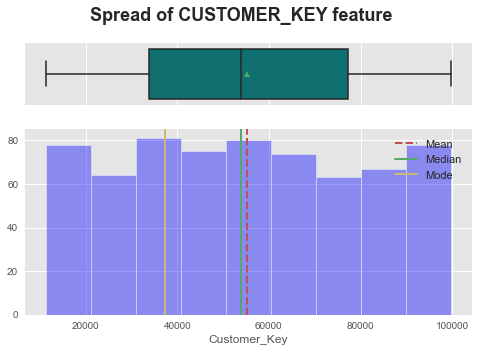

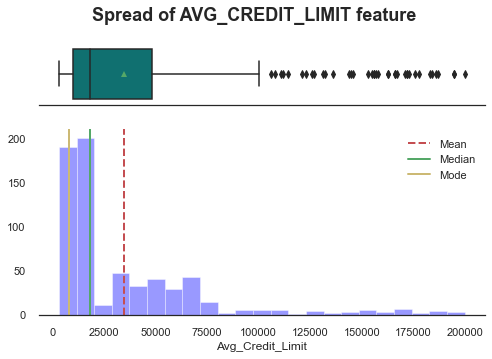

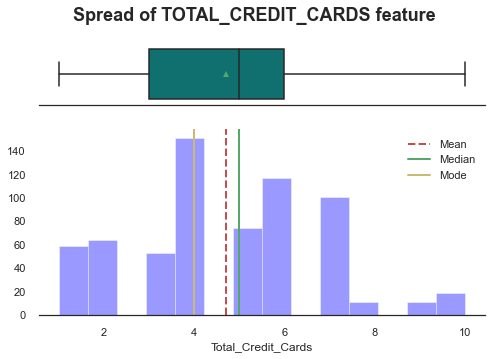

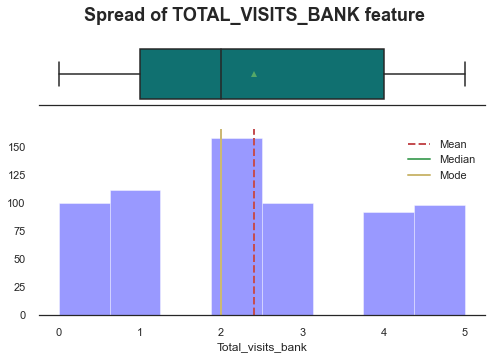

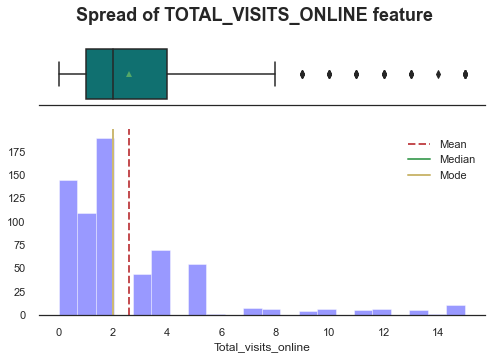

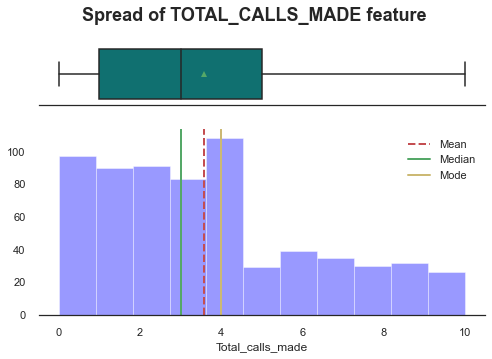

In [16]:
#select all quantitative columns for checking the spread
list_col = df.select_dtypes(include='number').columns.to_list()
for i in range(len(list_col)):
    dist_box(df[list_col[i]])

In [17]:
df.head()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3


<Figure size 1440x1440 with 0 Axes>

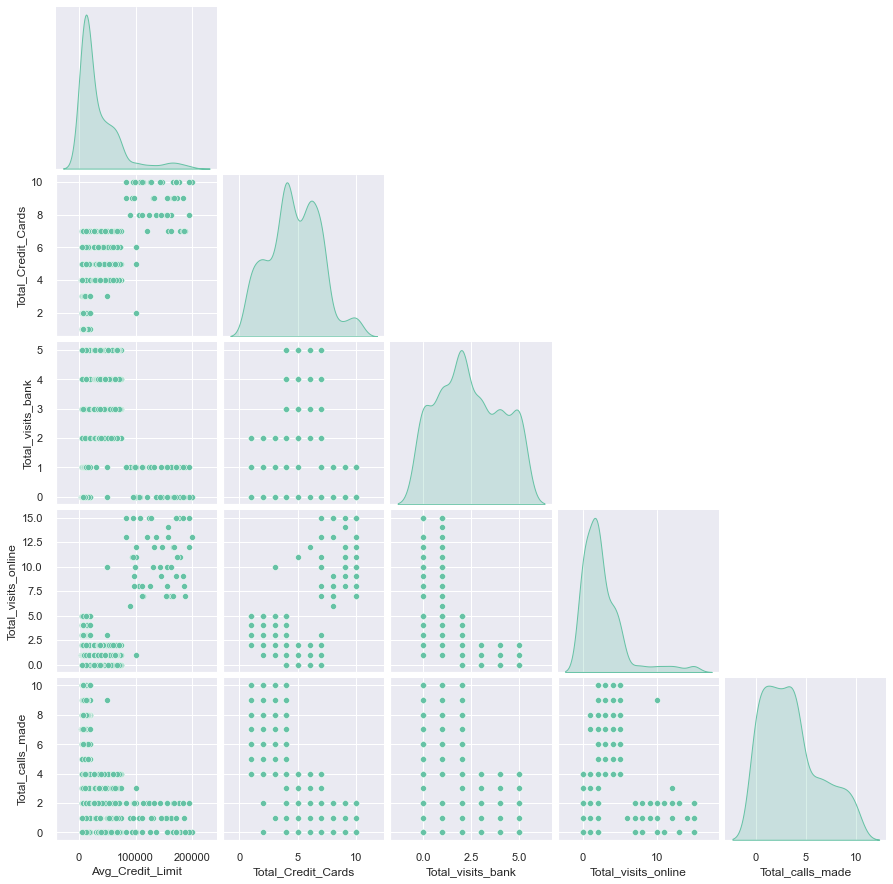

In [18]:
# pairplot of dataset
plt.figure(figsize=(20,20));
sns.set(palette="Set2");
sns.pairplot(df.iloc[:, 1:], diag_kind='kde', corner=True);

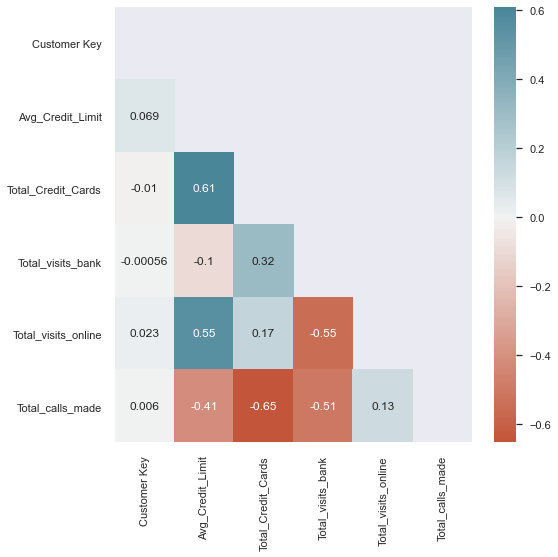

In [19]:
# Plotting correlation heatmap of the features

mask = np.zeros_like(data.iloc[:, 1:].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.set(rc={"figure.figsize": (8, 8)})

sns.heatmap(
    data.iloc[:, 1:].corr(),
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    mask=mask,
    center=0,
)
plt.show()

#### Observations
- Average Credit Limit has higest positive correlation with Total Credit Cards
- Total Number of Visits Online, and Total Calls Made are least positively correlated
- Total Credit Cards and Total Calls Made are negatively correlated
- Total Visits Online is also negatively correlated with Total Visits to Bank

In [20]:
# Function to plot numerical feature by each category with target hue

def plot_numeric_by_cat(data: pd.DataFrame, category_columns: list, numeric_column: str, hue: str = None):
    '''
    The function plots a numerical feature in box plot by every category column specified in the list, 
    with hue of a target category
    '''
    num_cols = 2
    num_rows = int(len(category_columns) /2 + 1)

    plt.figure(figsize=(20, 8*num_rows))
    for i, col in enumerate(category_columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.set(palette="nipy_spectral");
        sns.boxplot(data=data, x=col, y=numeric_column, hue=hue, showfliers=True).set(title = numeric_column + ' vs. ' + col );

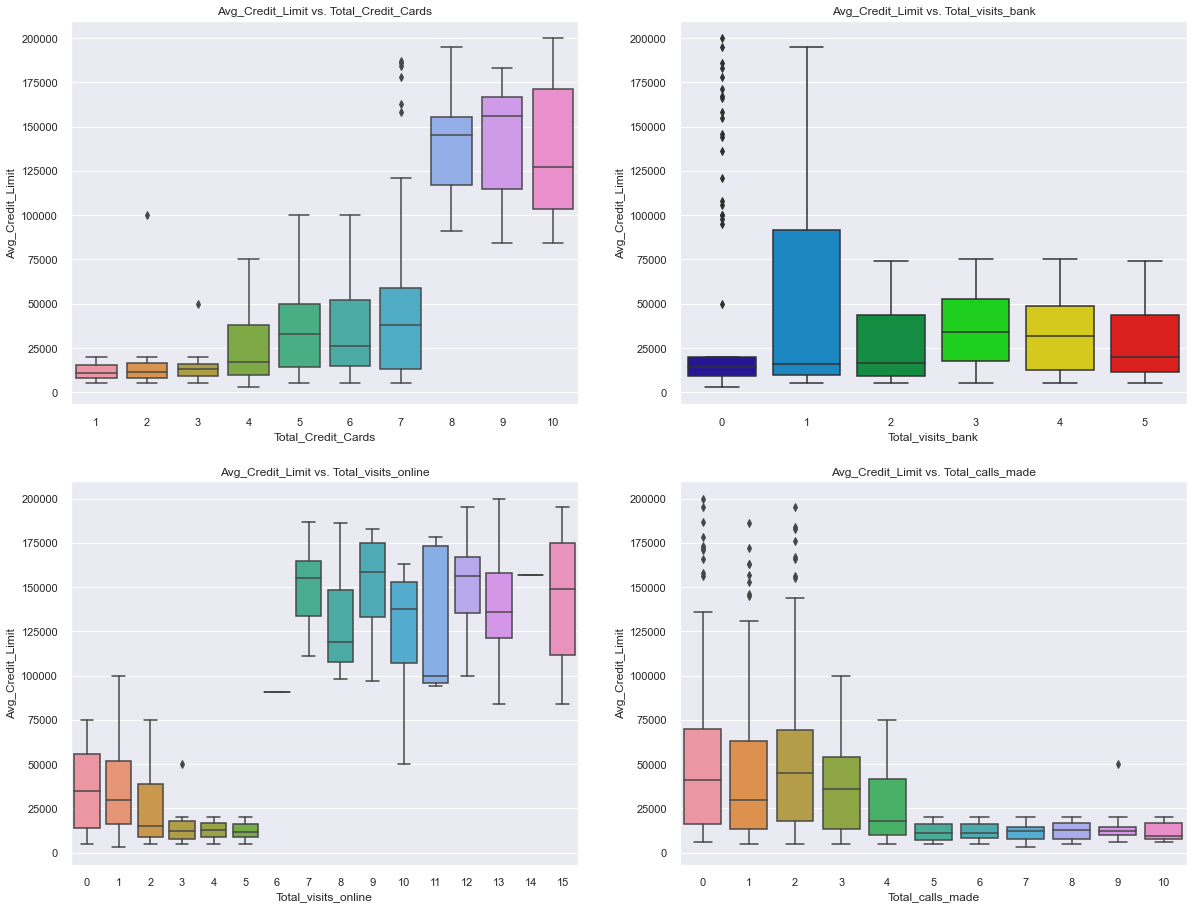

In [21]:
plot_numeric_by_cat(df\
                    ,category_columns=['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']\
                    ,numeric_column='Avg_Credit_Limit')

#### Observation
- We can see the clear segmentations with respect to each pair of features

In [22]:
df.head()

,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3


# Data Preprocessing
No duplicates, missing values in the dataset, we need to scale the data before appling clustering, no need of feature enginnering since we have enough data

In [23]:
# To find the 25th percentile and 75th percentile.
Q1 = df.quantile(0.25)  
Q3 = df.quantile(0.75)

IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)

lower = (
    Q1 - 1.5 * IQR
)  # Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper = Q3 + 1.5 * IQR

In [24]:
(
    (df.select_dtypes(include=["float64", "int64"]) < lower)
    | (df.select_dtypes(include=["float64", "int64"]) > upper)
).sum() / len(df) * 100

Customer_Key           0.000000
Avg_Credit_Limit       5.909091
Total_Credit_Cards     0.000000
Total_visits_bank      0.000000
Total_visits_online    5.606061
Total_calls_made       0.000000
dtype: float64

#### Observation
we can see that Avg credit limit and total visits online have outliers

In [25]:
# counting feature columns
category_columns=['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'] 
for col in category_columns:
    print(f"Feature: {col}")
    print("-"*40)
    display(pd.DataFrame({"Counts": df[col].value_counts(dropna=False)}).sort_values(by='Counts', ascending=False))

Feature: Total_Credit_Cards
----------------------------------------


,Counts
4,151
6,117
7,101
5,74
2,64
1,59
3,53
10,19
9,11
8,11


Feature: Total_visits_bank
----------------------------------------


,Counts
2,158
1,112
3,100
0,100
5,98
4,92


Feature: Total_visits_online
----------------------------------------


,Counts
2,189
0,144
1,109
4,69
5,54
3,44
15,10
7,7
12,6
10,6


Feature: Total_calls_made
----------------------------------------


,Counts
4,108
0,97
2,91
1,90
3,83
6,39
7,35
9,32
8,30
5,29


In [26]:
df.duplicated().sum() # no missing values

0

In [27]:
# scaling the dataset before clustering
data_copy = df.copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:,1:-1])

#### Observations

No missing or duplicated values in the dataset

# Data Modeling - Applying K-means Clustering
#### Finding the best numbr of centroids (K), elbow method

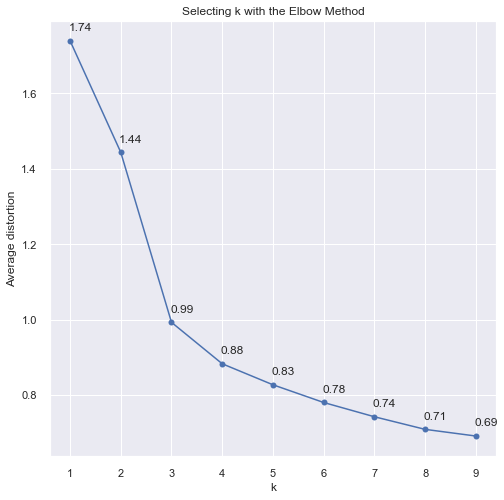

In [28]:
def best_centroids(data_scaled):
    """finding the best # of centroids"""
    clusters = range(1, 10)
    meanDistortions = []

    for k in clusters:
        model = KMeans(n_clusters=k)
        model.fit(data_scaled)
        prediction = model.predict(data_scaled)
        distortion = (
            sum(
                np.min(cdist(data_scaled, model.cluster_centers_, "euclidean"), axis=1)
            )
            / data_scaled.shape[0]
        )

        meanDistortions.append(distortion)


    plt.plot(clusters, meanDistortions, "bo-")
    plt.xlabel("k")
    plt.ylabel("Average distortion")
    plt.title("Selecting k with the Elbow Method")
    for x,y in zip(clusters, meanDistortions):

        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                     (x + 0.2,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()
best_centroids(data_scaled)

#### Observation
looks like k seems to be 3 cluster

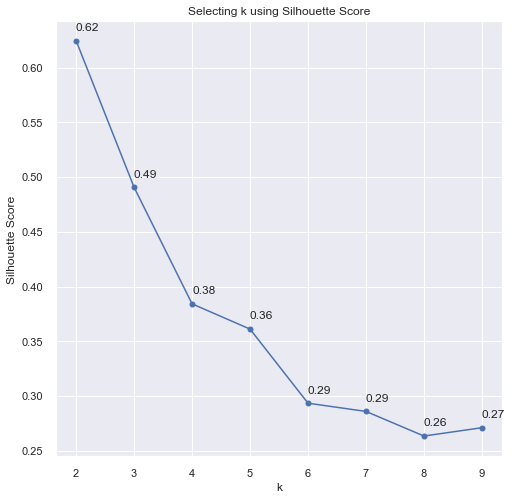

In [29]:
def k_silhoutte_score(data_scaled):
    """plotting the best """
    sil_score = []
    cluster_list = list(range(2, 10))
    for n_clusters in cluster_list:
        clusterer = KMeans(n_clusters=n_clusters)
        preds = clusterer.fit_predict((data_scaled))
        # centers = clusterer.cluster_centers_
        score = silhouette_score(data_scaled, preds)
        sil_score.append(score)


    plt.plot(cluster_list, sil_score, "bo-")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score ")
    plt.title("Selecting k using Silhouette Score")
    for x,y in zip(cluster_list, sil_score):

        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                     (x + 0.2,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()
k_silhoutte_score(data_scaled)

#### Observation
Silhouette score for 3 clusters is highest. So, we will choose 3 as value of k.

Let's also visualize the silhouettes created by each of the clusters for two values of k, 3 and 4

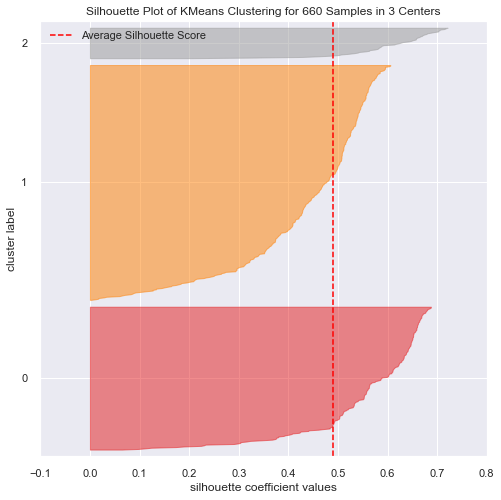

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

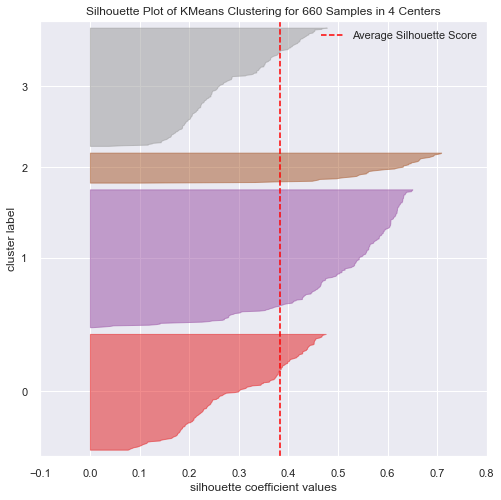

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [31]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(data_scaled)
visualizer.show()

#### Observation 3 clusters looks resonable

In [32]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled)

KMeans(n_clusters=3, random_state=0)

In [33]:
# adding kmeans cluster labels to the original and scaled dataframes
data_scaled_df = pd.DataFrame(data_scaled, columns=df.iloc[:,1:-1].columns.unique().tolist())
df['cluster'] = kmeans.labels_
data_scaled_df['cluster'] = kmeans.labels_


<Figure size 1440x1872 with 0 Axes>

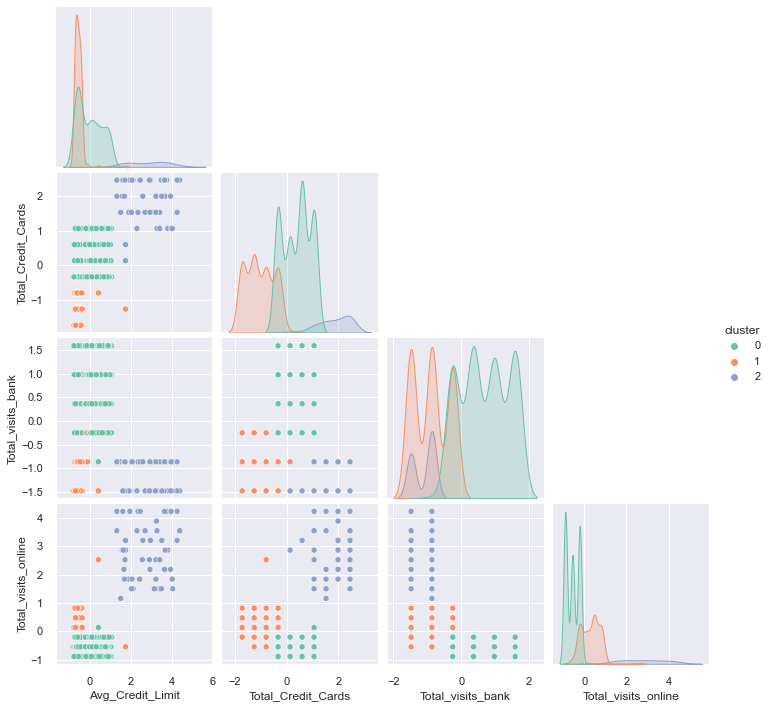

In [34]:
# pairplot of scaled data
plt.figure(figsize=(20, 26))

sns.pairplot(data_scaled_df, diag_kind='kde', corner=True, hue='cluster', palette='Set2');

<AxesSubplot:xlabel='Avg_Credit_Limit', ylabel='Total_Credit_Cards'>

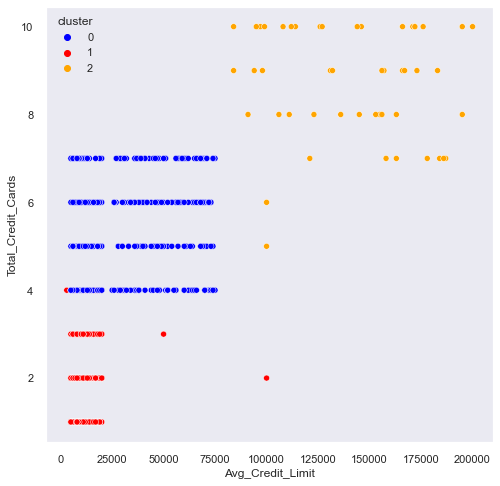

In [35]:
# scatterplot of total credit cards with hues of cluster
sns.set(style='dark')
sns.scatterplot(x=df['Avg_Credit_Limit'], y=df['Total_Credit_Cards'], hue=df['cluster'], palette=['blue', 'red', 'orange'])

In [36]:
# getting cluster profiles
cluster_profile = df.iloc[:,1:].groupby('cluster').mean()
cluster_profile['count_of_customers'] = df.groupby('cluster')['Customer_Key'].count()

cluster_profile.style.highlight_max(color='lightgreen').highlight_min(color='pink')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_of_customers
cluster,,,,,,
0,33846.965699,5.546174,3.522427,0.970976,2.005277,379
1,12722.943723,2.454545,0.956710,3.493506,6.714286,231
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


#### Hierarchical Clustering

In [37]:
# adding hierarchical cluster as cluster column
k_means_clusters = data_scaled_df['cluster']
data_scaled_df.drop(columns=['cluster'], inplace=True)

In [38]:
# list of distance metrics
distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'euclidean', 'hamming', 'jaccard', 'mahalanobis', 'matching', 'minkowski', 'seuclidean',  'sqeuclidean']

# list of linkage methods
linkage_methods = ['complete', 'average', 'single', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(data_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Braycurtis distance and complete linkage is 0.39176119731975095.
Cophenetic correlation for Braycurtis distance and average linkage is 0.5879159090819478.
Cophenetic correlation for Braycurtis distance and single linkage is 0.8196651774995096.
Cophenetic correlation for Braycurtis distance and weighted linkage is 0.5190565467540516.
Cophenetic correlation for Canberra distance and complete linkage is 0.5145038904608642.
Cophenetic correlation for Canberra distance and average linkage is 0.6190797248559778.
Cophenetic correlation for Canberra distance and single linkage is 0.7930628028807007.
Cophenetic correlation for Canberra distance and weighted linkage is 0.6672464987325829.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8817290543635519.
Cophenetic correlation for Chebyshev distance and average linkage is 0.900440204126547.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8116018823705033.
Cophenetic correlat

In [39]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9029995575233576, which is obtained with average linkage.


#### Observation
We see that the cophenetic correlation is maximum with Euclidean distance and Average Linkage.



#### Dendograms
A dendrogram, in general, is a diagram that shows the hierarchical relationship between objects.

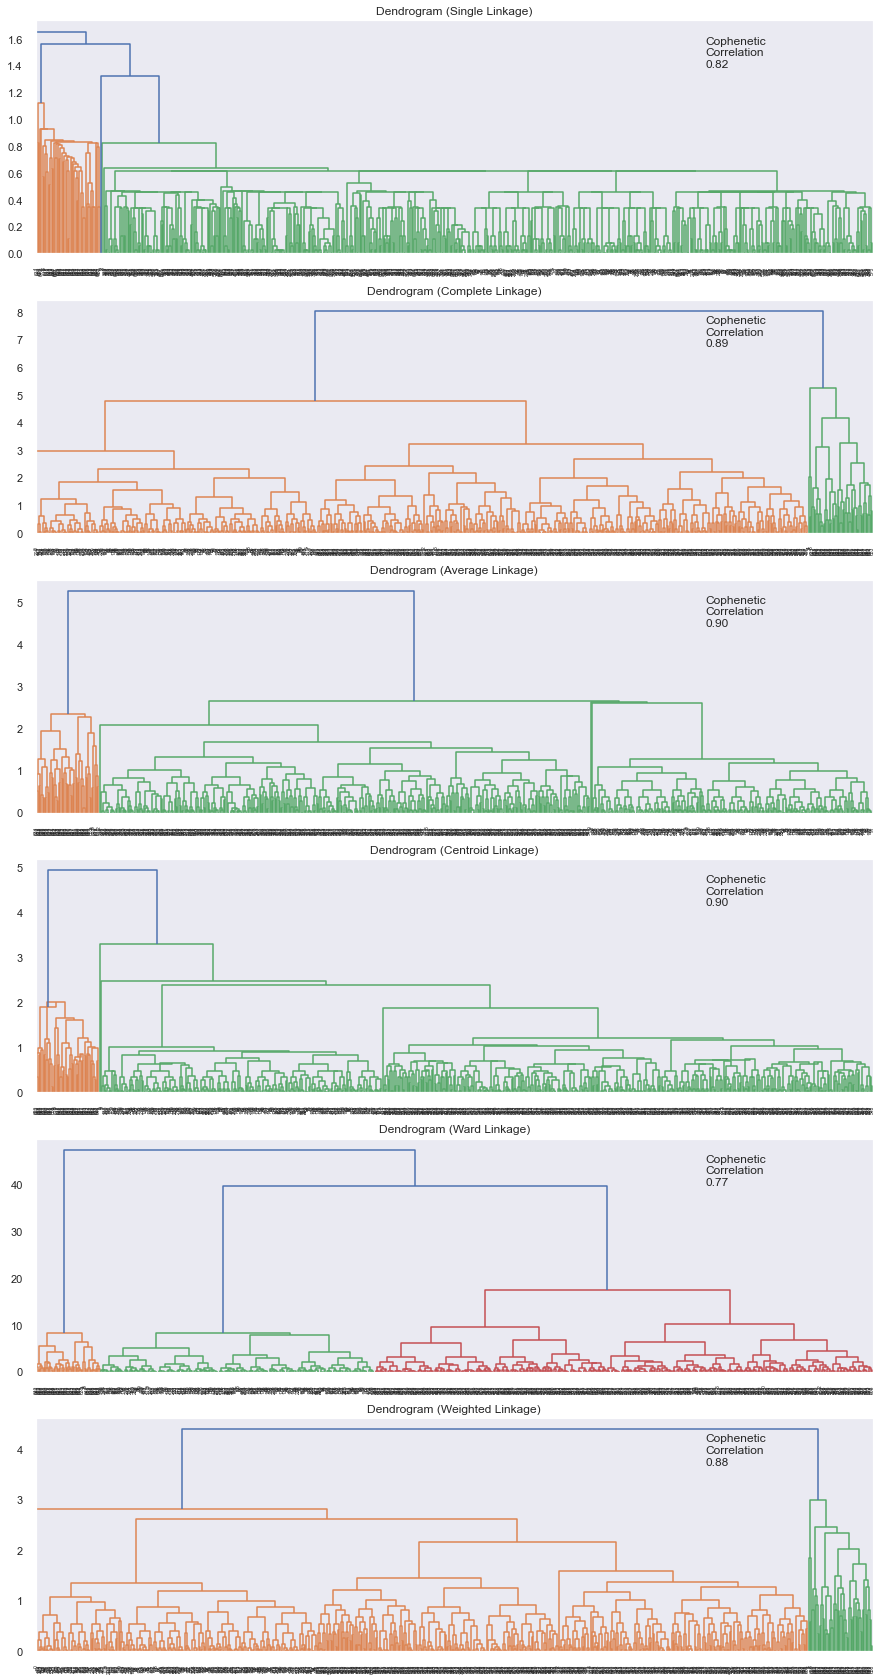

In [40]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(data_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

#### Agglomerative Clustering model

In [41]:
# applying agglometric cluster with euclidean distance metric
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(data_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [42]:
# getting the labels
data_scaled_df['hc_cluster'] = HCmodel.labels_
data['hc_cluster'] = HCmodel.labels_

In [43]:
df.columns

Index(['Customer_Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made',
       'cluster'],
      dtype='object')

#### Cluster profiling

In [44]:
# cluster profiling
cluster_profile_hc = df.iloc[:,1:].groupby('cluster').mean()
cluster_profile_hc['count_of_customers'] = df.groupby('cluster')['Customer_Key'].count()

cluster_profile_hc.style.highlight_max(color='lightgreen').highlight_min(color='pink')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_of_customers
cluster,,,,,,
0,33846.965699,5.546174,3.522427,0.970976,2.005277,379
1,12722.943723,2.454545,0.956710,3.493506,6.714286,231
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


#### Actionable insights and Recommendations
There appears to be three distinct categories of customers:

- In-person users: prefer to handle bank transactions in person. They have the medium number of credit cards and the medium available credit. They are also the most active users.
- Phone users: prefer verbally handling transactions. They have fewest credit cards and lowest credit card limit.
- Online users: prefer digital transactions. They also have the most credit cards and the highest available credit. Least number of customers have this type of behaviour.

The customer preferences should be used to contact the customers. Online/phone users will probably prefer email/text notifications, while in-person users prefer mail notifications and upselling (when at the bank location).

Also, the phone and in-person customers should be reached out to promote online banking.